# First computer exercise in Machine Learning: Unsupervised methods
==============================================================================================================


## Part A: Principal Component Analysis

Write a function that performs PCA on a (not necessarily centered) data in a 2D numpy array. The function should return the pca transformed data along with the eigenvalues and eigenvectors of the tranformation. You can use the numpy package. 

In [1]:
import numpy as np
# Use the numpy eigenvalue solver for the covariance matrix
E, V = np.linalg.eig(np.array([[0,2], [1, 1]]))
# The solver doesn't return ordered eigenvalues, so we have to fix this
key = np.argsort(E)[::-1]
V = V[:,key]
E = E[key]
print(E)
print(V)

[ 2. -1.]
[[-0.70710678 -0.89442719]
 [-0.70710678  0.4472136 ]]


In [2]:
# delete me: https://stackoverflow.com/questions/13224362/principal-component-analysis-pca-in-python
# XXX: I don't think that it's pythonic to have capital letters in function names
def PCA2(data, pca_components=2):
    """
    PCA with eigenvalues
    
    :param data: A 2d numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :returns: tuple (U, E, V) 
        WHERE
        U is a numpy array of the pca transformed data
        E is an descending numpy array of eigenvalues
        V is an numpy array of eigenvectors such that eigenvalue E[i] corresponds to V[i,:]
    """
    ### YOUR CODE STARTS HERE ###
    
    m, n = data.shape
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric, 
    # the performance gain is substantial
    evals, evecs = np.linalg.eig(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    E = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    V = evecs[:, :pca_components]
    U = np.dot(V.T, data.T).T
    V = np.transpose(V)
    ### YOUR CODE ENDS HERE ###
    return (U, E, V)

We will begin with the MNIST data set https://en.wikipedia.org/wiki/MNIST_database. It is commonly used for "hello world" purposes in machine learning.

The shape of the data vector XX is: (1797, 64)
The shape of the label vector YY is: (1797,)


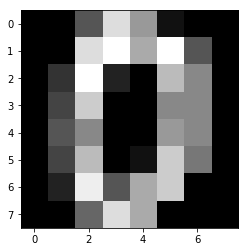

In [3]:
import matplotlib.pyplot as plt 
from course_utils import *

#  The images have been scaled down to 8x8 pixels, and will be stored in a flat numpy vector. 
XX, YY = load_mnist_data()
print("The shape of the data vector XX is: {}".format(XX.shape))
print("The shape of the label vector YY is: {}" .format(YY.shape))
# Display a sample
plt.imshow(np.reshape(XX[0,:], (8, 8)), cmap="gray")
plt.show()

Check that your function outputs a solution that agrees with the canonical python implementation of PCA

In [170]:
# XXX: I can just do this for randn_data like I do below for K-Means, it's weird to introduce MNIST before testing PCA

In [4]:
from sklearn.decomposition import PCA
(U, E, V) = PCA2(XX, 2)
pca = PCA(n_components=2)
pca.fit(XX)
if np.transpose(V).shape == pca.components_.shape:
    print("Try transposing your eigenvector output")
assert(np.allclose([1, 1], np.abs(np.diagonal(np.inner(V, pca.components_)))))
print("Passed)

Success!


In [5]:
X, Y = load_ini_data2()
clusters = len(np.unique(Y))

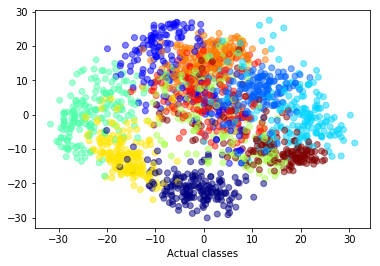

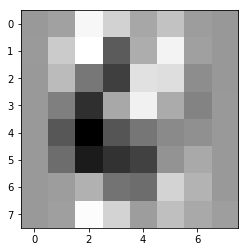

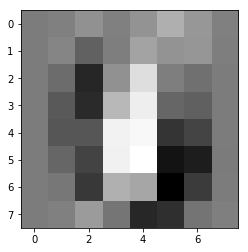

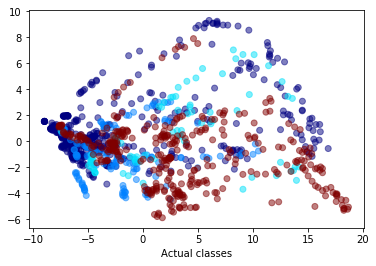

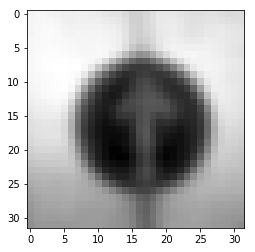

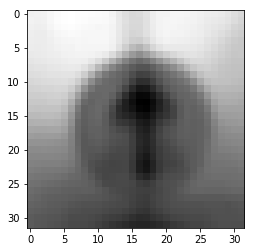

In [6]:
# Viz with 2 pca components
pca_features, _, _ = PCA2(XX, 2)
plt.xlabel('Actual classes')
plt.scatter(pca_features[:,0], pca_features[:,1], c=YY, alpha=0.5, cmap="jet")
plt.show()
for i in range(2):
    comp_image = np.reshape(V[i,:], (8,8))
    plt.imshow(comp_image, cmap="gray")
    plt.show()
pca_features, _, V = PCA2(X, 2)
plt.xlabel('Actual classes')
plt.scatter(pca_features[:,0], pca_features[:,1], c=Y, alpha=0.5, cmap="jet")
plt.show()
for i in range(2):
    comp_image = np.reshape(V[i,:], (32, 32))
    plt.imshow(comp_image, cmap="gray")
    plt.show()


In [126]:
# XXX: I want to introduce SFA before K-means, so they can immediately run k-means on the sfa features for nice viz.
# This also allows for whitening to come immediately after PCA and right before SFA
# The score calculations then follow the k-means 

## Part D: K-Means clustering


Complete this function that calculates the reconstruction error of a clustering assignment according to the lecture notes.

In [124]:
def KM_error(data, centroids, assignment):
    """
    K-Means error
    
    :param data: A 2D numpy array where data.shape == (number_of_data_points, dimensionality_of_data)
    :param centroids: A 2D numpy array where centroids.shape == (n_clusters, dimensionality_of_data)
    :param assignment: A list defining the allocation of the data to clusters such that data[i,:] belongs to
                       cluster assignment[i], corresponding to centroids[clustering[i]]
                       assume that the cluster labels are integers in 0, ..., n_clusters
    
    :returns total_error: The reconstruction error of the clustering (eq. 1 lecture notes on clustering)
    """
    ### YOUR CODE STARTS HERE ###
    total_error = 0
    for i in range(data.shape[0]):
        total_error += np.linalg.norm(data[i,:]   -   centroids[assignment[i]])**2
    ### YOUR CODE ENDS HERE ###
    return total_error 

Test KM_error, there should be no error when you run the cell below.

In [125]:
from sklearn.cluster import KMeans
kmeans = KMeans(init='random', n_clusters=5)
rnd_data = np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], 100)
kmeans.fit(rnd_data)
assert(np.allclose(kmeans.inertia_, KM_error(rnd_data, kmeans.cluster_centers_, kmeans.labels_)))
print("Passed")

Now write a function that calculates the optimal choice of cluster centers:

In [122]:
def KM_centers(data, assignment, n_clusters):
    """
    K-Means centroids
    
    :param data: A 2D numpy array where data.shape == (number_of_data_points, dimensionality_of_data)
    :param assignment: A list defining the allocation of the data to clusters such that data[i,:] belongs to
                       cluster assignment[i]
                       assume that the cluster labels are integers in 0, ..., n_clusters
    :param n_clusters: the upper bound on the values that the elements in assignment can take
    
    :returns centroids: A 2D numpy array where centroids.shape == (n_clusters, dimensionality_of_data),
                        calculated according to eq. 2 in the lecture notes on clustering
    
    """
    ### YOUR CODE STARTS HERE ###
    centroids = np.zeros((n_clusters, data.shape[1]))
    N = np.zeros(n_clusters)
    for i in range(len(N)):
        N[i] = np.sum(1 for j in assignment if j == i)
    for i in range(data.shape[0]):
        centroids[assignment[i]] += data[i,:]
    for i in range(n_clusters):
        for j in range(data.shape[1]):
            centroids[i,j]/=N[i] 
    ### YOUR CODE ENDS HERE ###
    return centroids


Test KM_centers:

In [123]:
kmeans = KMeans(init='random', n_clusters=5)
rnd_data = np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], 100)
kmeans.fit(rnd_data)
assert(np.allclose(kmeans.cluster_centers_, KM_centers(rnd_data, kmeans.labels_, 5)))
print("Passed")

Write a k-means clustering algorithm that gets a numpy array of data, along with a number $k$ of clusters and a convergence threshold. Use the functions you wrote above and choose the initial center locations randomly from the data points.

In [7]:
import numpy as np
def Kmeans2(data, n_clusters, threshold):
    """
    K-Means Clustering
    
    :param data: A 2d numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :param n_clusters: The number of clusters the algorithm finds
    :param threshold: The minimum change in eq. 1 (lecture notes on clustering) before algorithm stops 
    :returns assignment: a list of class assignments such that point data[i,:] belongs to cluster assignment[i]
    """
    
    ### YOUR CODE STARTS HERE ###
        
    ### YOUR CODE ENDS HERE ###
    return assignment

## Part B: Whitening

Use your PCA implemention to complete this whitening function.

In [17]:
from sklearn.decomposition import PCA #XX: Delete me before course

def whiten(data):
    """
    K-Means Clustering

    :param data: A 2d numpy array of where data.shape == (number_of_data_points,
                 dimensionality_of_data_points), assume that the data is centered
    :returns: tuple (whitened_data, whitening_matrix) 
        WHERE
        whitened_data is the transformed input data whose covariance is the identity matrix
        whitening_matrix is the transformation that yields the whitening: 
                         np.dot(whitening_matrix, data.T) == whitened_data.T
    """

    ### YOUR CODE STARTS HERE ###
    X = np.array(data)
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    (U, E, V) = PCA2(X, X.shape[1])
    Lambda = np.zeros((len(pca.singular_values_), len(pca.singular_values_)))
    np.fill_diagonal(Lambda, np.power(E, -0.5))
    X = np.dot(np.dot(Lambda, V), X.T)
    whitened_data = X
    whitening_matrix = np.dot(Lambda, V)
    ### YOUR CODE ENDS HERE ###
    
    return (whitened_data, whitening_matrix)

See if the function returns whitened data

In [15]:
import numpy as np
rnd_data = np.random.multivariate_normal([0, 0], [[3, 4], [5, 6]], 1000)
print(rnd_data.shape)
whitened_data, whitening_matrix = whiten(rnd_data)
assert(np.allclose(np.identity(2), np.cov(whitened_data)))
print("Passed")

(1000, 2)
Passed


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


Check whether the original data can be approximately recovered:

In [6]:
inverse_whitening = np.linalg.inv(whitening_matrix)
recovered_data = np.dot(inverse_whitening, whitened_data)
if recovered_data.shape != rnd_data.shape:
    recovered_data = recovered_data.T
assert(np.allclose(rnd_data, recovered_data, atol=0.1))
print("Passed")

Passed


Inspect the effect of whitening

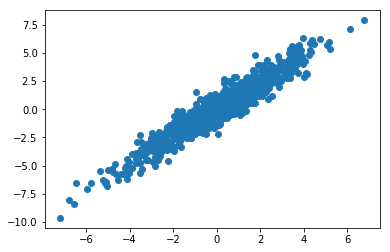

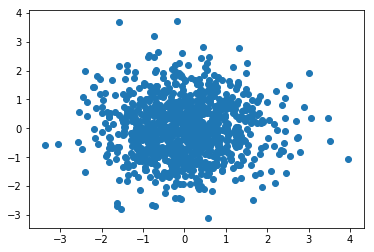

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(rnd_data[:,0], rnd_data[:,1])
plt.show()
if rnd_data.shape != whitened_data.shape:
    whitened_data = whitened_data.T
plt.scatter(whitened_data[:,0], whitened_data[:,1])
plt.show()

## Part C: Slow Feature Analysis

Use your PCA and whitening functions to implement SFA.

In [131]:
def slow_feature_analysis(data, n_features):
    """
    Slow Feature Analysis
    
    :param data: A numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :param n_features: The number of slowest features to calculate for each point
    
    :returns sfa_transformed_data: An array of the sfa transformed data with shape (data.shape[0], n_features)
    """
    ### YOUR CODE STARTS HERE ###
    whitened_data, _ = whiten(data)
    whitened_data = whitened_data.T
    derivative = lambda Z: Z[1:, :]-Z[:-1, :]
    whitened_derivatives = derivative(whitened_data)
    (U, E, V) = PCA2(whitened_derivatives, data.shape[1])
    sfa_transformed_data = whitened_data.dot(V)
    sfa_transformed_data = np.fliplr(sfa_transformed_data)
    ### YOUR CODE ENDS HERE ###
    return sfa_transformed_data

See if your function agrees with the standard implementation:

In [133]:
import mdp
sfa_dims = 2
sfa = mdp.nodes.SFANode(output_dim=sfa_dims)
rnd_data = np.random.multivariate_normal([0, 0], [[3, 4], [5, 6]], 1000)
try:
    assert(np.allclose(slow_feature_analysis(rnd_data, sfa_dims), sfa.execute(rnd_data), atol=1e-2))
except:
    assert(np.allclose(-1*slow_feature_analysis(rnd_data, sfa_dims), sfa.execute(rnd_data), atol=1e-2))
print("Passed")

Passed


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


c:\users\bubu\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\bubu\appdata\local\programs\python\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
c:\users\bubu\appdata\local\programs\python\python36\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all 

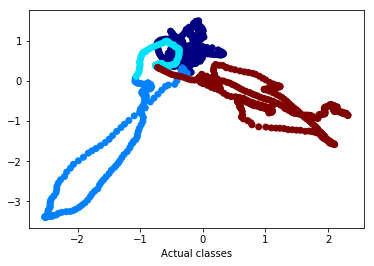

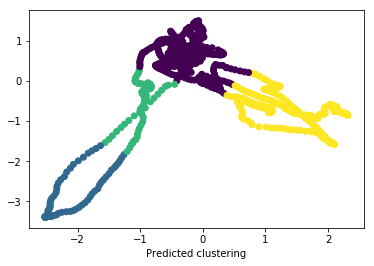

In [8]:
# Viz with 2 sfa features
# TODO: Swap out the KMeans function calls with Kmeans2
from sklearn.cluster import KMeans
import mdp

sfa = mdp.nodes.SFANode(output_dim=2)
slow_features = sfa.execute(X)
# slow_features = > function from assignment 5 <  
kmeans = KMeans(init='random', n_clusters=clusters)
kmeans.fit(slow_features)
classes = kmeans.predict(slow_features)
# classes = > function from assignment 3 <  
plt.scatter(slow_features[:,0], slow_features[:,1], c=Y, cmap="jet")
plt.xlabel("Actual classes")
plt.show()

plt.scatter(slow_features[:,0], slow_features[:,1], c=classes)
plt.xlabel("Predicted clustering")
plt.show()

## Bonus: Cluster scoring

In [9]:
# Same as above, but now with SFA features. 
# Here they should find that all metrics are significantly better
# with a good number of SFA features: turns out that exploiting
# the knowledge that the data is ordered is pretty useful.
from time import time
from sklearn import metrics

sfa_features = [2, 5, 10, 20, 50, 99]
for features in sfa_features:  
    t0 = time()
    sfa = mdp.nodes.SFANode(output_dim=features)
    slow_features = sfa.execute(X)
    # slow_features = > function from assignment 5 <  
    kmeans = KMeans(init='random', n_clusters=clusters)
    kmeans.fit(slow_features)
    classes = kmeans.predict(slow_features)
    # classes = > function from assignment 3 <  
    print("{} sfa components, Purity: {:.2}, ARI: {:.2}, Seconds: {:.2} ".format(features,
                                             purity_score(Y, classes),
                                             metrics.adjusted_rand_score(Y, classes),
                                                              time() - t0))
    
t0 = time()
kmeans = KMeans(init='random', n_clusters=clusters)
kmeans.fit(X)
classes = kmeans.predict(X)
# classes = > function from assignment 3 <  

print("raw pixels\t , Purity: {:.2}, ARI: {:.2}, Seconds: {:.2}".format(purity_score(Y, classes),
                                    metrics.adjusted_rand_score(Y, classes),
                                    time() - t0))


2 sfa components, Purity: 0.85, ARI: 0.6, Seconds: 0.59 
5 sfa components, Purity: 0.79, ARI: 0.45, Seconds: 0.59 
10 sfa components, Purity: 0.81, ARI: 0.55, Seconds: 0.62 
20 sfa components, Purity: 0.61, ARI: 0.21, Seconds: 0.57 
50 sfa components, Purity: 0.56, ARI: 0.11, Seconds: 0.73 
99 sfa components, Purity: 0.48, ARI: -0.027, Seconds: 0.83 
raw pixels	 , Purity: 0.59, ARI: 0.16, Seconds: 2.1


In [10]:
# Functions that I imagine requiring students to implement: 
# purity_score(y_true, y_predicted), davies_bouldin_score(X, y_predicted)
# DONE: the equivalent of pca.fit_transform(n_components, X)
# DONE: and kmeans.predict(n_clusters, X)
# DONE: and some sort of "sfa.fit_transform(n_features, X)"